# Analyis of ERPs

## Optiones

In [44]:
bids_root_path= "/media/marc/Medien/machristine-bids"
bids_root_path= "/media/marc/Medien/machristine-bids"
pipeline_name = "pipeline_christine"

## Loading Dependencies and Defining Functions
Load MNE and read configuration file.

In [45]:
from ...configuration.configuration import load_configuration

import utils

from os.path import join
import mne
from mne_bids import make_bids_basename, read_raw_bids
from mne_bids.utils import get_entity_vals

import plotting

import seaborn as sns

config = load_configuration()
%matplotlib notebook


In [46]:
def difference_wave(evokeds_as_dict, conditions, grandaverage=False):
    out = [mne.combine_evoked([a, b], [1,-1]) for a, b in zip(
        evokeds_as_dict[conditions[0]], evokeds_as_dict[conditions[1]])]
    if grandaverage:
        return mne.grand_average(out)
    else:
        return out

## Read averaged ERPs from disk

Read averaged ERPs for each participant:

In [47]:
%%capture
ids = get_entity_vals(join(bids_root_path, "derivatives"), "sub") 
ave_filenames = [utils.get_derivative_file_name(
        bids_root_path, id, pipeline_name, ".fif", suffix="ave") for id in ids]
all_evokeds = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames]

Turn list of dicts of ERPs into dict of lists of ERPs:

In [48]:
evokeds_list_as_dict = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds:
    for evoked in evokeds_list:
        evokeds_list_as_dict[evoked.comment].append(evoked)

## Find Preak Latency and Window
Following Sussmann (2005), peak laency is defined as the latency where the differnce wave between deviant and standard tones in the random condition reaches its maximum (within the `Fz` channel).

In [49]:
# Find peak and find a window (±25ms) 
diff = difference_wave(evokeds_list_as_dict, ("random/nopattern/deviant", "random/nopattern/standard"), grandaverage=True)
peak_latency = diff.pick(picks="FZ").get_peak(tmin = .1, tmax = .2,  return_amplitude = True)[1]

peakwindow = (peak_latency-0.025, peak_latency+0.025)

print("Peak Latency is {} s.".format(peak_latency))

Identifying common channels ...
Peak Latency is 0.134765625 s.


## Difference Waves (nopattern)

<IPython.core.display.Javascript object>


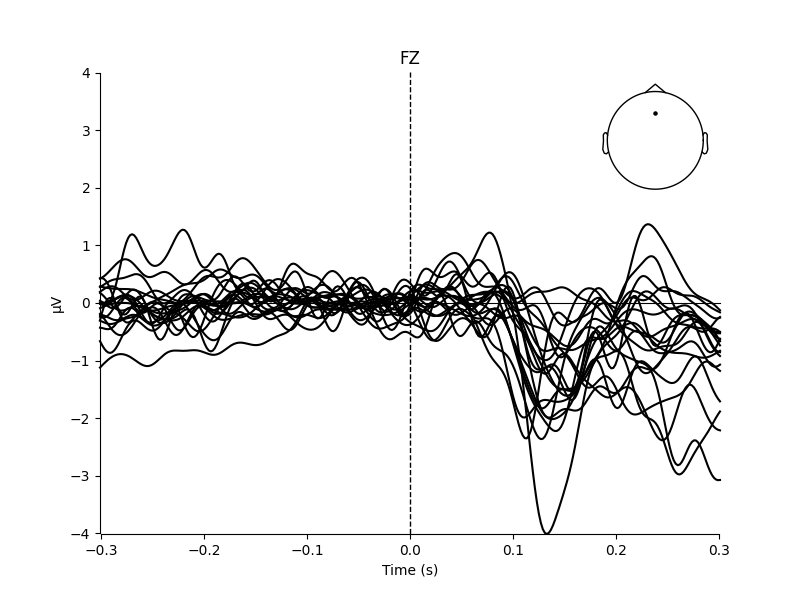

[<Figure size 800x600 with 2 Axes>]

In [50]:
diff_waves = {str(n):mne.combine_evoked([eb, ea], weights=[1, -1]) for ea, eb, n in zip(evokeds_list_as_dict["random/nopattern/standard"], evokeds_list_as_dict["random/nopattern/deviant"], range(20))}
mne.viz.plot_compare_evokeds(diff_waves, picks="FZ", ci=False, colors=["black"]*25, legend=False)

## Visualize different Standards
Standards differ depending on their position in repsect to the preceeding deviant. Let's compare standards in the `random` condition:

<IPython.core.display.Javascript object>


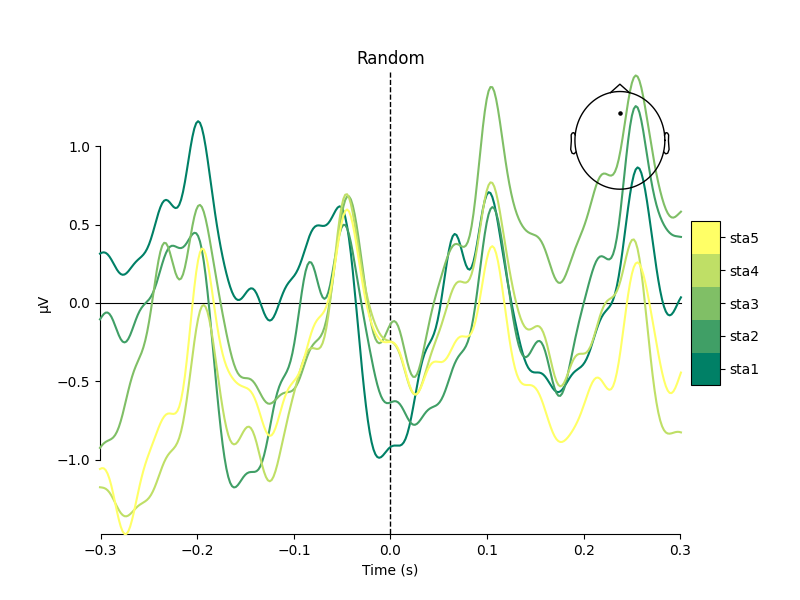

[<Figure size 800x600 with 3 Axes>]

In [51]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["random/1/standard"],
                                 "sta2":evokeds_list_as_dict["random/2/standard"],
                                 "sta3":evokeds_list_as_dict["random/3/standard"],
                                 "sta4":evokeds_list_as_dict["random/4/standard"],
                                 "sta5":evokeds_list_as_dict["random/5/standard"]}, picks="FZ", ci=False, cmap="summer", title="Random")

Now we do the same for standardars in the `predicatble` condition:

<IPython.core.display.Javascript object>


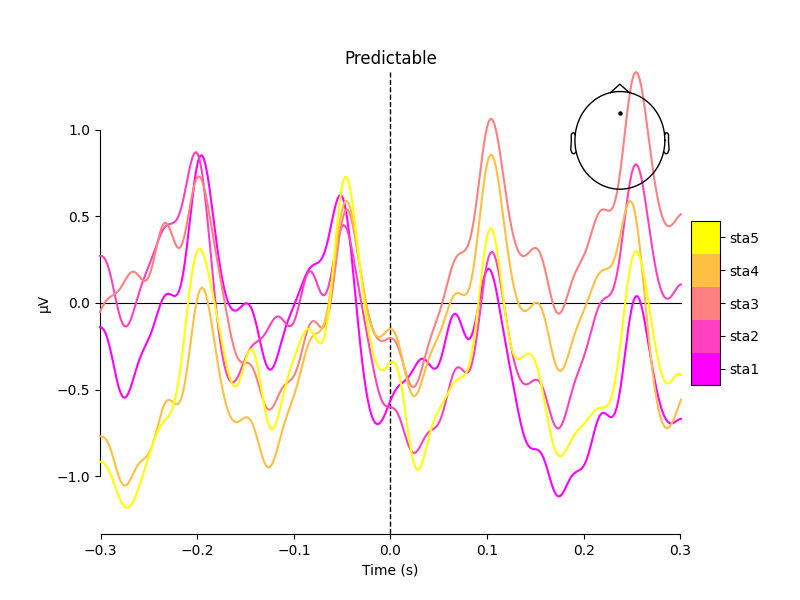

[<Figure size 800x600 with 3 Axes>]

In [52]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["predictable/1/standard"],
                                 "sta2":evokeds_list_as_dict["predictable/2/standard"],
                                 "sta3":evokeds_list_as_dict["predictable/3/standard"],
                                 "sta4":evokeds_list_as_dict["predictable/4/standard"],
                                 "sta5":evokeds_list_as_dict["predictable/5/standard"]}, picks="FZ", ci=False, cmap="spring", title="Predictable")

## Compare `nopattern` `standards` and `deviants` in the `random` condition

First, we take a look at the `Fz` channel:

<IPython.core.display.Javascript object>


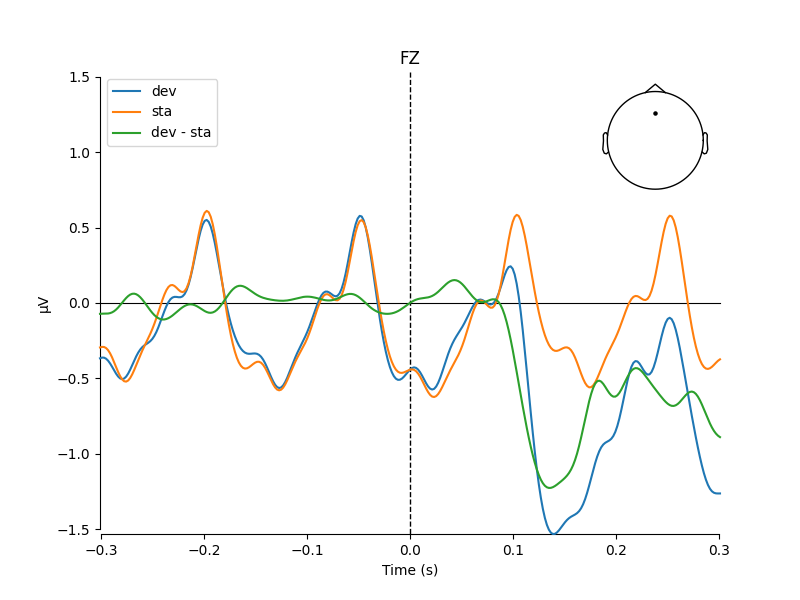

[<Figure size 800x600 with 2 Axes>]

In [65]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/nopattern/deviant"],
                                 "sta":evokeds_list_as_dict["random/nopattern/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/nopattern/deviant", "random/nopattern/standard"])}, 
                                 picks=["FZ"], ci=False)

And for the mastoids (mean of `M1` and `M2`):

<IPython.core.display.Javascript object>


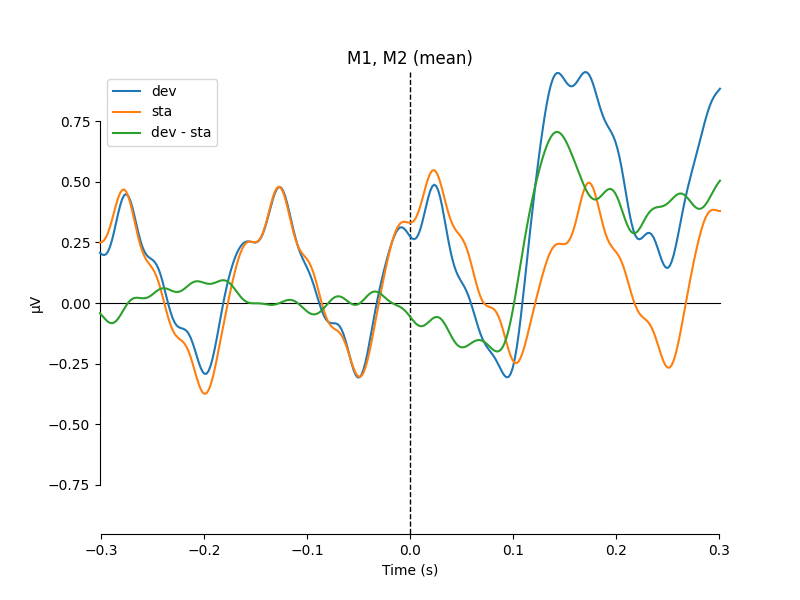

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [54]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/nopattern/deviant"],
                                 "sta":evokeds_list_as_dict["random/nopattern/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/nopattern/deviant", "random/nopattern/standard"])}, 
                                 picks=["M1", "M2"], combine="mean", ci=False)

We can also re-refernce out signals to the mastoids and then plot the timecourse for `Fz`:

In [55]:
%%capture
re_ref_dev = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/nopattern/deviant"]]
re_ref_sta = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/nopattern/standard"]]
re_ref_diff = [e.set_eeg_reference(["M1", "M2"]) for e in difference_wave(evokeds_list_as_dict, ["random/nopattern/deviant", "random/nopattern/standard"])]

<IPython.core.display.Javascript object>


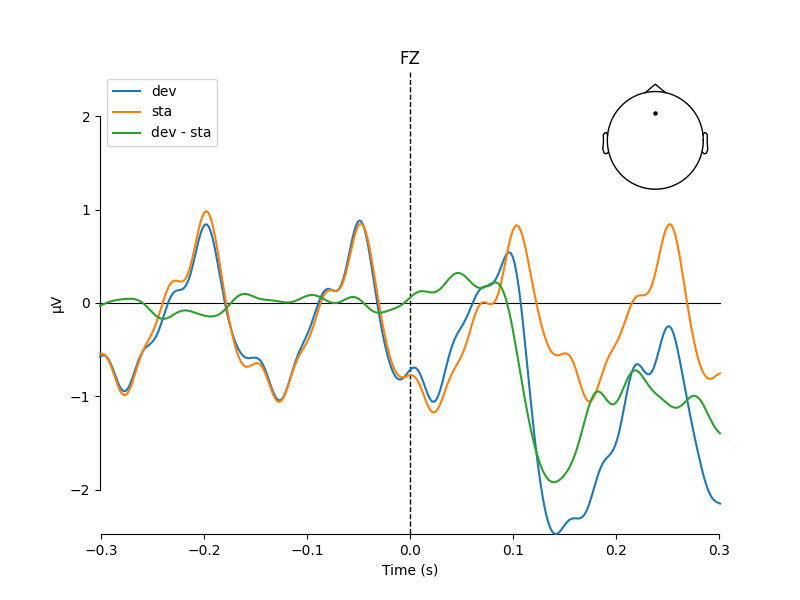

[<Figure size 800x600 with 2 Axes>]

In [56]:
mne.viz.plot_compare_evokeds(   {"dev": re_ref_dev,
                                 "sta": re_ref_sta,
                                 "dev - sta": re_ref_diff}, picks="FZ", ci=False)

## Comparing the 5th standard and the 5th deviant in the random condition

<IPython.core.display.Javascript object>


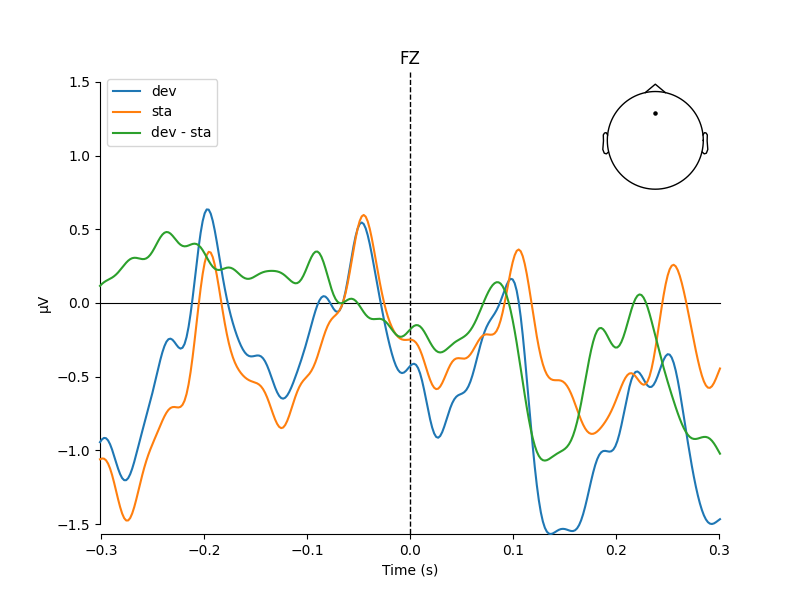

[<Figure size 800x600 with 2 Axes>]

In [57]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/5/deviant"],
                                 "sta":evokeds_list_as_dict["random/5/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/5/standard"])}, 
                                 picks=["FZ"], ci=False)

<IPython.core.display.Javascript object>


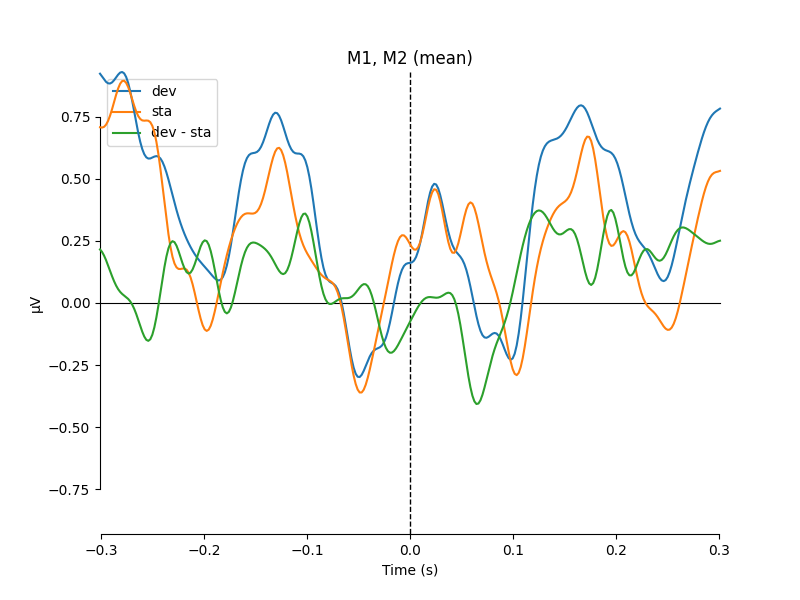

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [58]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/5/deviant"],
                                 "sta":evokeds_list_as_dict["random/5/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/5/standard"])}, 
                                 picks=["M1", "M2"], combine="mean", ci=False)

In [59]:
%%capture
re_ref_dev = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/5/deviant"]]
re_ref_sta = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/5/standard"]]
re_ref_diff = [e.set_eeg_reference(["M1", "M2"]) for e in difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/5/standard"])]

<IPython.core.display.Javascript object>


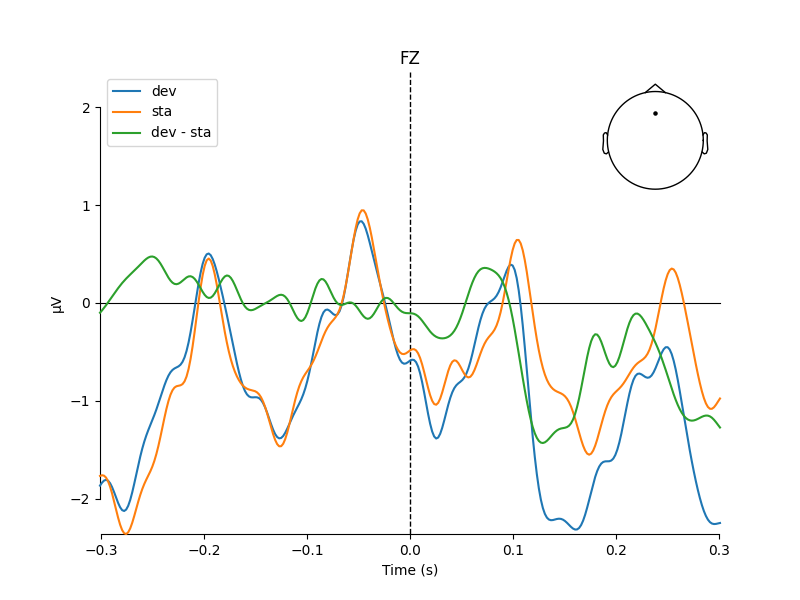

[<Figure size 800x600 with 2 Axes>]

In [60]:
mne.viz.plot_compare_evokeds(   {"dev": re_ref_dev,
                                 "sta": re_ref_sta,
                                 "dev - sta": re_ref_diff}, picks="FZ", ci=False)

## Comparing the 4th `standard`and the 5th `deviant`

### In the `random`condition

<IPython.core.display.Javascript object>


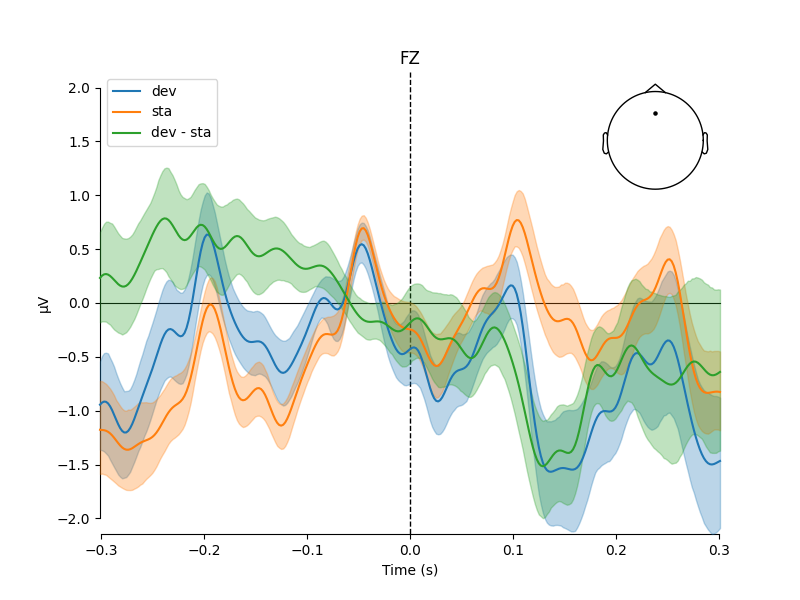

[<Figure size 800x600 with 2 Axes>]

In [73]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/5/deviant"],
                                 "sta":evokeds_list_as_dict["random/4/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/4/standard"])}, 
                                 picks=["FZ"], ci=True)

<IPython.core.display.Javascript object>


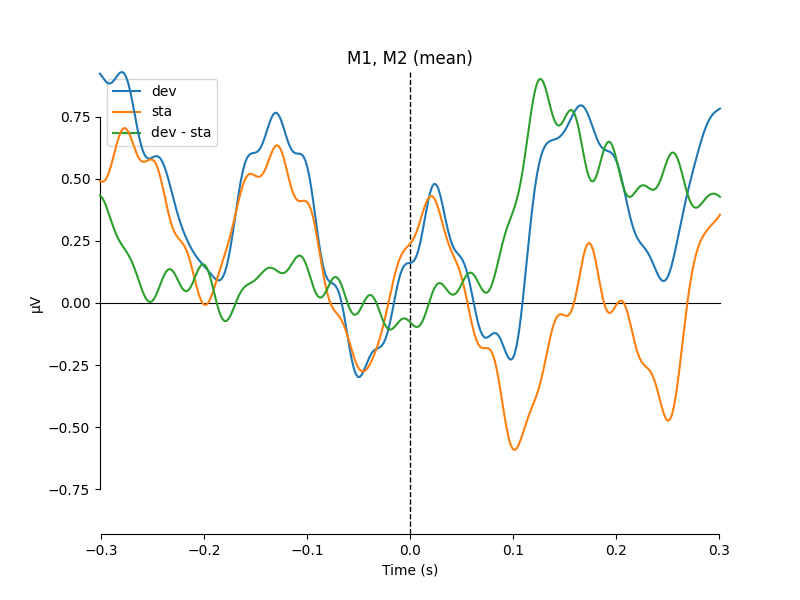

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [62]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["random/5/deviant"],
                                 "sta":evokeds_list_as_dict["random/4/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/4/standard"])}, 
                                 picks=["M1", "M2"], combine="mean", ci=False)

In [63]:
%%capture
ref_dev = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/5/deviant"]]
re_ref_sta = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["random/4/standard"]]
re_ref_diff = [e.set_eeg_reference(["M1", "M2"]) for e in difference_wave(evokeds_list_as_dict, ["random/5/deviant", "random/4/standard"])]

<IPython.core.display.Javascript object>


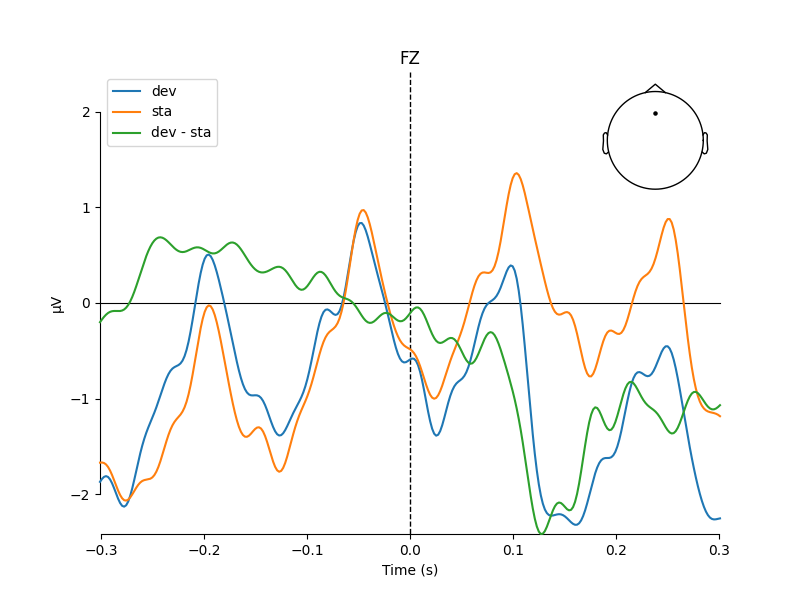

[<Figure size 800x600 with 2 Axes>]

In [64]:
mne.viz.plot_compare_evokeds(   {"dev": re_ref_dev,
                                 "sta": re_ref_sta,
                                 "dev - sta": re_ref_diff}, picks="FZ", ci=False)

### In the predictable condition

<IPython.core.display.Javascript object>


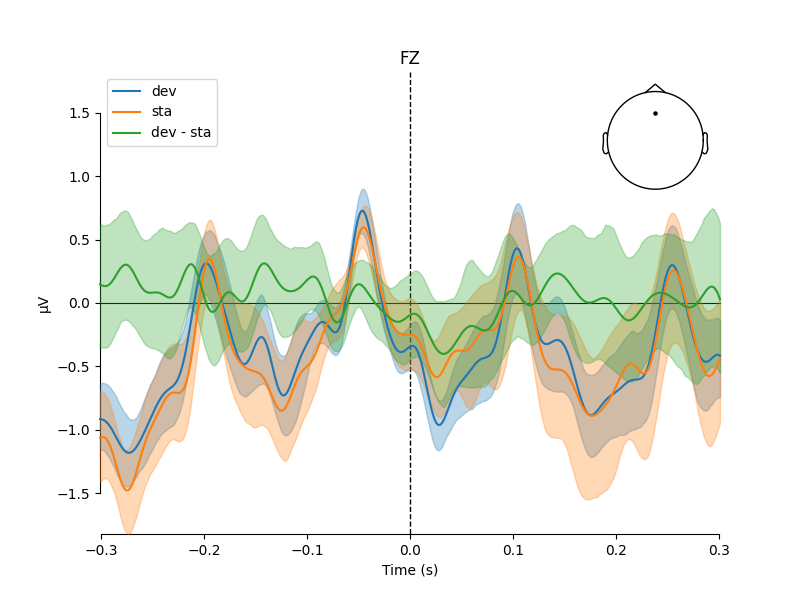

[<Figure size 800x600 with 2 Axes>]

In [82]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["predictable/5/standard"],
                                 "sta":evokeds_list_as_dict["random/5/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["predictable/5/standard", "random/5/standard"])}, 
                                 picks=["FZ"], ci=True)

<IPython.core.display.Javascript object>


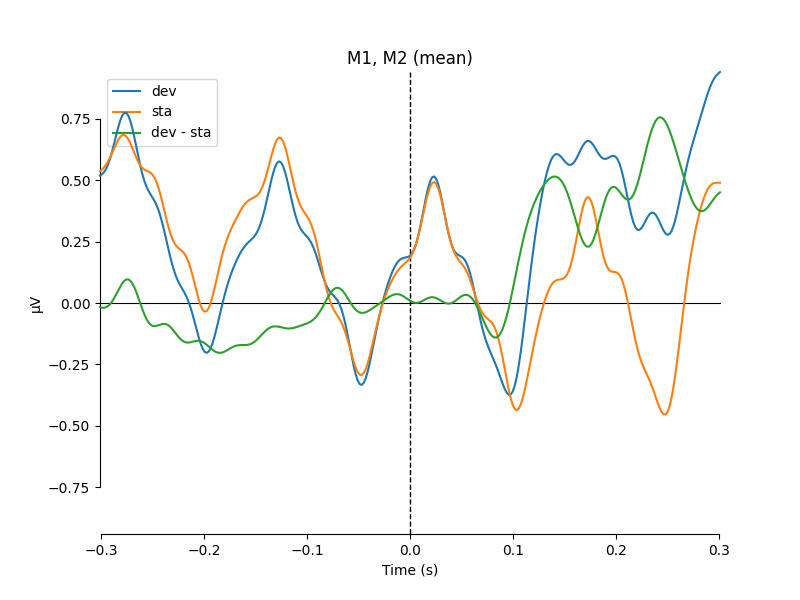

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [67]:
mne.viz.plot_compare_evokeds(   {"dev":evokeds_list_as_dict["predictable/5/deviant"],
                                 "sta":evokeds_list_as_dict["predictable/4/standard"],
                                 "dev - sta": difference_wave(evokeds_list_as_dict, ["predictable/5/deviant", "predictable/4/standard"])}, 
                                 picks=["M1", "M2"], combine="mean", ci=False)

In [68]:
%%capture
re_ref_dev = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["predictable/5/deviant"]]
re_ref_sta = [e.copy().set_eeg_reference(["M1", "M2"]) for e in evokeds_list_as_dict["predictable/4/standard"]]
re_ref_diff = [e.set_eeg_reference(["M1", "M2"]) for e in difference_wave(evokeds_list_as_dict, ["predictable/5/deviant", "random/4/standard"])]

<IPython.core.display.Javascript object>


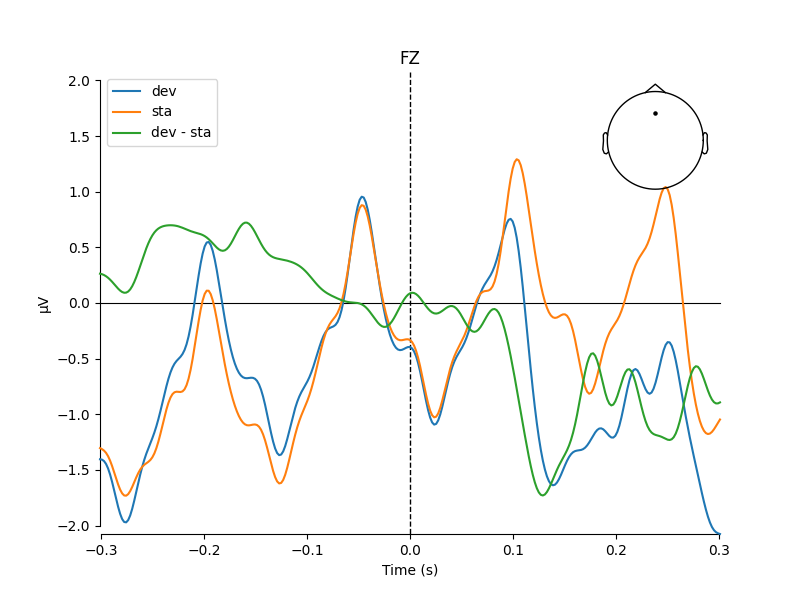

[<Figure size 800x600 with 2 Axes>]

In [76]:
mne.viz.plot_compare_evokeds(   {"dev": re_ref_dev,
                                 "sta": re_ref_sta,
                                 "dev - sta": re_ref_diff}, picks="FZ", ci=False)

In [77]:
import seaborn as sns
import numpy as np
import pandas as pd

vals_a = np.zeros(20)
vals_b = np.zeros(20)

for id in ids:
    id = int(id) -1
    diff_wave_a = mne.combine_evoked([evokeds_list_as_dict["random/nopattern/deviant"][id], evokeds_list_as_dict["random/nopattern/standard"][id]], weights=[1,-1]) 
    diff_wave_b = mne.combine_evoked([evokeds_list_as_dict["random/5/deviant"][id], evokeds_list_as_dict["random/5/standard"][id]], weights=[1,-1]) 

    vals_a[id] = diff_wave_a.pick("FZ").data[0, diff_wave_a.time_as_index(peak_latency)]
    vals_b[id] = diff_wave_b.pick("FZ").data[0, diff_wave_b.time_as_index(peak_latency)]

data = {"id": ids, "MMNRandomNopattern": vals_a, "MMNRandom5": vals_b}

sns.scatterplot(data = data, x="MMNRandomNopattern", y="MMNRandom5")


IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:
mne.grand_average(evokeds_list_as_dict["random/5/deviant"]).copy().crop(0,.3).plot_joint(show=False, topomap_args={"cmap":"rainbow"})

In [ ]:
pip install jupyter_contrib_nbextensions

<IPython.core.display.Javascript object>


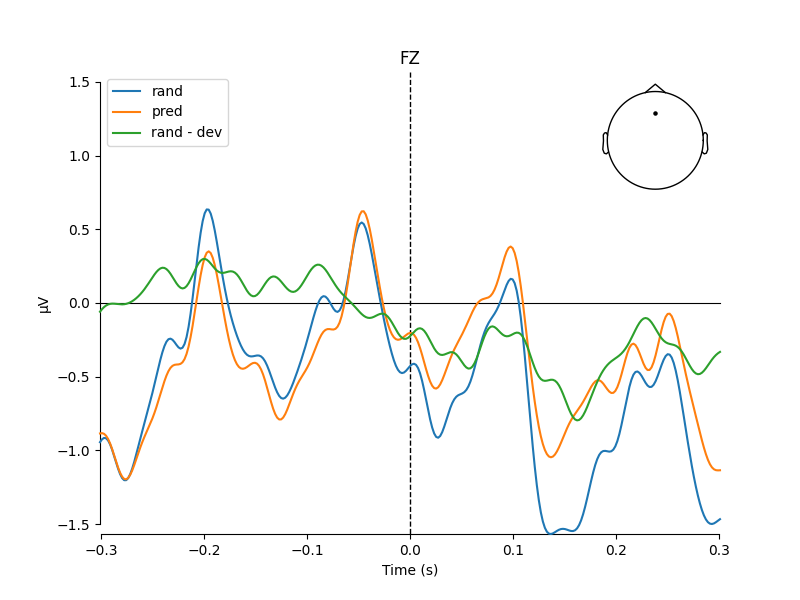

[<Figure size 800x600 with 2 Axes>]

In [79]:
mne.viz.plot_compare_evokeds(   {"rand":evokeds_list_as_dict["random/5/deviant"],
                                 "pred":evokeds_list_as_dict["predictable/5/deviant"],
                                 "rand - dev": difference_wave(evokeds_list_as_dict, ["random/5/deviant", "predictable/5/deviant"])}, 
                                 picks=["FZ"], ci=False)

<IPython.core.display.Javascript object>


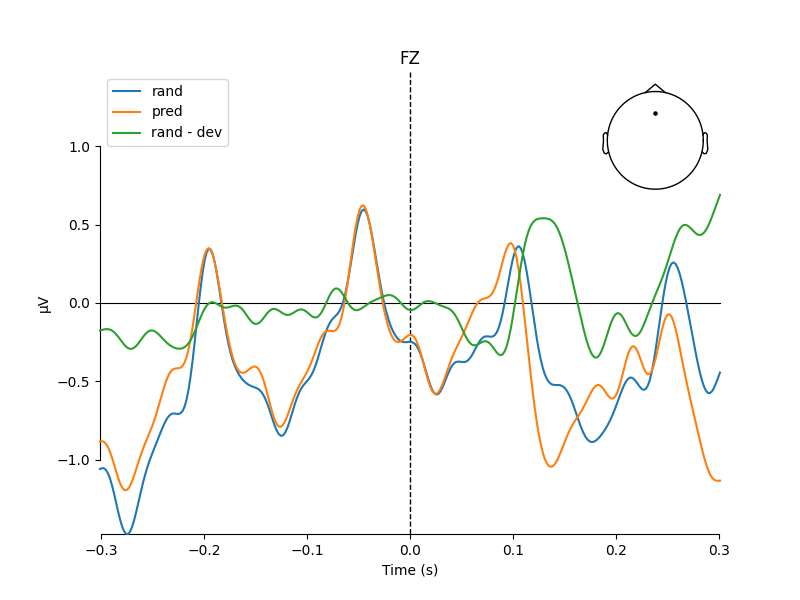

[<Figure size 800x600 with 2 Axes>]

In [80]:
mne.viz.plot_compare_evokeds(   {"rand":evokeds_list_as_dict["random/5/standard"],
                                 "pred":evokeds_list_as_dict["predictable/5/deviant"],
                                 "rand - dev": difference_wave(evokeds_list_as_dict, ["random/5/standard", "predictable/5/deviant"])}, 
                                 picks=["FZ"], ci=False)

In [ ]:
mne.viz.plot_compare_evokeds(   {"rand":evokeds_list_as_dict["predictable/5/standard"],
                                 "pred":evokeds_list_as_dict["predictable/5/deviant"],
                                 "rand - dev": difference_wave(evokeds_list_as_dict, ["predictable/5/standard", "predictable/5/deviant"])}, 
                                 picks=["FZ"], ci=False)

Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


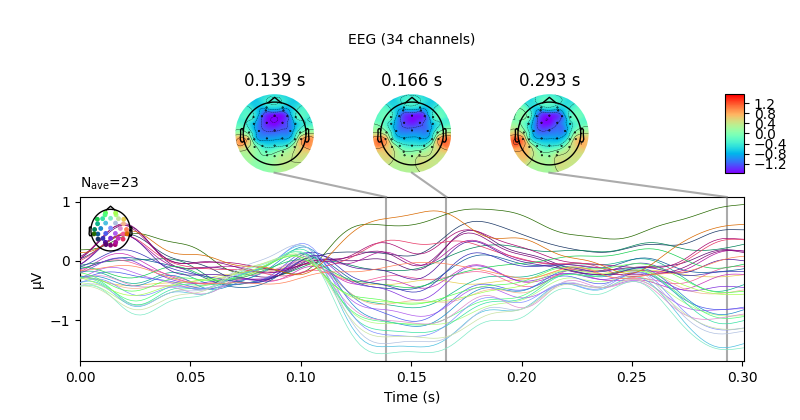

<IPython.core.display.Javascript object>


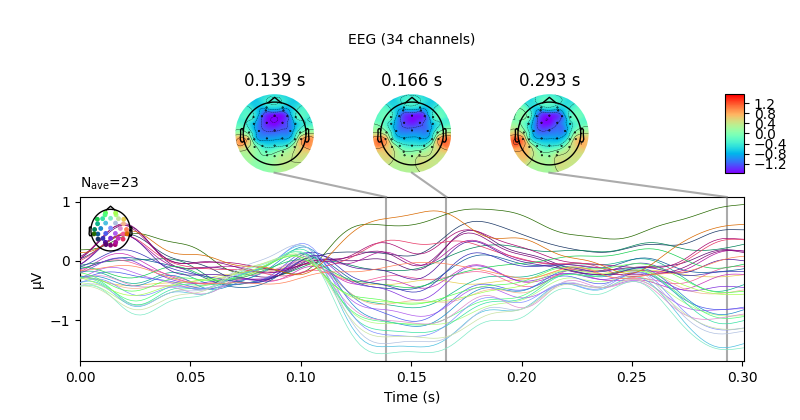

In [83]:
mne.grand_average(evokeds_list_as_dict["random/5/deviant"]).copy().crop(0,.3).plot_joint(show=False, topomap_args={"cmap":"rainbow"})